In [356]:
import numpy as np
import pandas as pd
from DataProcessing import Data
import matplotlib.pyplot as plt
import seaborn as sns                       #visualisation
sns.set_theme(color_codes=True)

# 1. Get Data 

## 1.1. Get Data from folder

In [357]:
d = Data()
d.get_index_names()

S&P 500: ['AAPL', 'ORCL', 'GOOGL', 'AMZN', 'BK', 'LIFE', 'T', 'XOM']
 VN: ['VHM', 'CTR', 'FPT', 'MBB']


['AAPL',
 'ORCL',
 'GOOGL',
 'AMZN',
 'BK',
 'LIFE',
 'T',
 'XOM',
 'VHM',
 'CTR',
 'FPT',
 'MBB']

In [358]:
chosen_index = 'GOOGL'

In [359]:
d.preprocess(chosen_index)

Processing GOOGL.csv


Saved GOOGL data at data/processed/GOOGL.csv


In [360]:
df = d.get_data(chosen_index)

In [361]:
df.columns

Index(['Date', 'Close', 'Volume', 'RSI', 'MFI', 'EMA', 'SO', 'MACD',
       'Next Day Price'],
      dtype='object')

# 2. Train model

In [362]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  train_test_split

In [363]:
X = df[df.columns[1:8]].values
Y = df[df.columns[8]].values

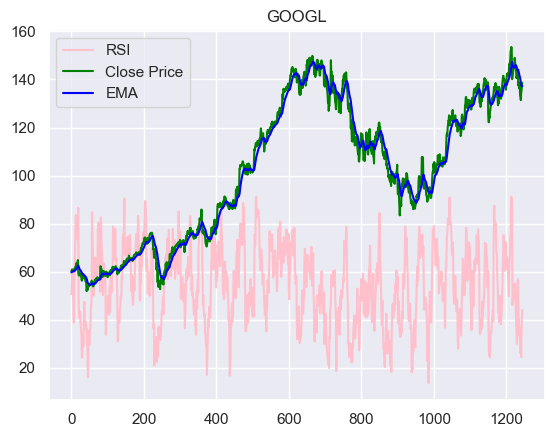

In [364]:
plt.plot(df['RSI'],color='pink',label='RSI')
plt.plot(Y,color='green',label='Close Price')
plt.plot(df['EMA'],color='blue',label='EMA')
# legend
plt.legend(loc='best')
plt.title(f'{chosen_index}')
plt.show()

## 2.1. Split data

### 2.1.2. Unchronologically

In [365]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=37)

### 2.1.2. Chronologically

In [366]:
TRAIN_PERCENT = 0.8
train_size = int(TRAIN_PERCENT*len(X))

X_train = X[0:train_size]
Y_train = Y[0:train_size]
X_test = X[train_size:len(X)]
Y_test = Y[train_size:len(Y)]

## 2.2. Train model

In [367]:
model = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
model.fit(X_train,Y_train)
model.score(X_test,Y_test)

0.9534878970440561

# Evaluation

In [368]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error

oob_score = model.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions = model.predict(X_test)

mse = mean_squared_error(Y_test, predictions)
# print(f'Mean Squared Error: {mse}')

r2 = r2_score(Y_test, predictions)
print(f'R-squared: {r2}')

rmse = root_mean_squared_error(Y_test, predictions)
print(f'Root Mean Squared Error: {rmse}')

mape = mean_absolute_percentage_error(Y_test, predictions)
print(f'Mean Absolute Percentage Error: {mape}')


Out-of-Bag Score: 0.9945533375340192
R-squared: 0.9534878970440561
Root Mean Squared Error: 2.708664342937673
Mean Absolute Percentage Error: 0.015797072604661035


## Plot Result

In [369]:
Y_predict = model.predict(X_test)

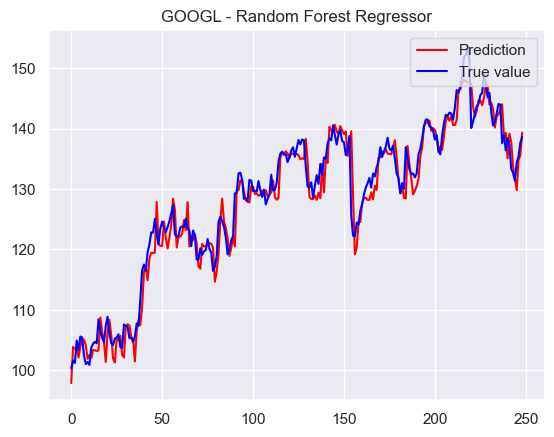

In [370]:
plt.plot(Y_predict,color='red',label='Prediction')
plt.plot(Y_test,color='blue',label='True value')
plt.legend(loc='upper right')
plt.title(f'{chosen_index} - Random Forest Regressor')
plt.show()